# Эксперименты для научной работы "Гибридный подход к распознаванию рукописного текста"
## Описание данных
Файлы формата .txd содержат штриховое разложение одной строки рукописного текста.
Что хранится в файле:
1. Заголовок
Название файла. Общее число штрихов в этой строке текста. Ось строки -- базовая линия текста (вертикальная координата середины строки)
2. Структура каждого штриха
Номер штриха, тип штриха, количество точек, уровень, позиция в слове
3. Типы штрихов:
* Chain -- цепочка точек (обычный штрих)
* Ring -- замкнутый контур (кольцо)
* StickVert -- вертикальная линия/отрезок
* StickHor -- горизонтальная линия/отрезок
4. Позиция в слове (по факту BIO-разметка)
* Начало слова -- первый штрих слова
* Середина слова -- средние штрихи
* Конец слова -- последние штрихи
5. Данные точек
Система координат -- правая декартовая система, как в математике, а не в изображении
Начало координат -- левый нижний угол изображения
Единицы изображения -- пиксели, но с высокой точностью (до сотых)
Ось строки -- вертикальная координата, которая делит изображение пополам

In [2]:
import re
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional


@dataclass
class StrokePoint:
    x: float
    y: float
    param: float


@dataclass
class Stroke:
    id: int
    type: str
    num_points: int
    position: str
    points: List[StrokePoint]

    @property
    def coordinates(self) -> List[Tuple[float, float]]:
        return [(p.x, p.y) for p in self.points]


@dataclass
class TXDData:
    filename: str
    axis_y: float
    total_strokes: int
    strokes: List[Stroke]

    def get_stroke_by_id(self, stroke_id: int) -> Optional[Stroke]:
        for stroke in self.strokes:
            if stroke.id == stroke_id:
                return stroke
        return None

    def get_strokes_by_type(self, stroke_type: str) -> List[Stroke]:
        return [s for s in self.strokes if s.type == stroke_type]

    def get_stroke_by_position(self, position: str) -> List[Stroke]:
        return [s for s in self.strokes if s.position == position]


class TXDParser:
    def __init__(self):
        self.patterns = {
            'header': re.compile(r'^(.+\.bmp)\s+(\d+)\s+штрихов$'),
            'axis': re.compile(r'.*[Оо]сь строки\s*Y=(\d+)', re.IGNORECASE),
            'stroke_header': re.compile(
                r'^\s*[Шш]трих\s+(\d+)\s+(\w+)\s+точек\s+(\d+)\s+строка\s+\d+\s+уровень\s+базовый\s+(.+)$'
            ),
            'point': re.compile(r'^\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*$')
        }

    def parse_file(self, file_path: str) -> TXDData:
        with open(file_path, 'r', encoding='windows-1251') as f:
            lines = f.readlines()
        return self._parse_lines(lines)

    def parse_content(self, content: str) -> TXDData:
        lines = content.split('\n')
        return self._parse_lines(lines)

    def _parse_lines(self, lines: List[str]) -> TXDData:
        filename, total_strokes = self._parse_header(lines[0])
        axis_y = self._parse_axis(lines[1])

        strokes = []
        i = 2
        while i < len(lines):
            line = lines[i].strip()
            if not line:
                i += 1
                continue
            stroke_match = self.patterns['stroke_header'].match(line)
            if stroke_match:
                stroke_id = int(stroke_match.group(1))
                stroke_type = stroke_match.group(2)
                num_points = int(stroke_match.group(3))
                position = stroke_match.group(4)

                points = []
                for j in range(1, num_points + 1):
                    if i + j < len(lines):
                        point_line = lines[i + j].strip()
                        point_match = self.patterns['point'].match(point_line)
                        if point_match:
                            x = float(point_match.group(1))
                            y = float(point_match.group(2))
                            param = float(point_match.group(3))
                            points.append(StrokePoint(x, y, param))
                stroke = Stroke(
                    id=stroke_id,
                    type=stroke_type,
                    num_points=num_points,
                    position=position,
                    points=points
                )
                strokes.append(stroke)
                i += num_points + 1
            else:
                print('Отвергли строку:', stroke)
                i += 1
        return TXDData(
            filename=filename,
            axis_y=axis_y,
            total_strokes=total_strokes,
            strokes=strokes
        )

    def _parse_header(self, line: str) -> Tuple[str, int]:
        match = self.patterns['header'].match(line.strip())
        if match:
            return match.group(1), int(match.group(2))
        raise ValueError(f'Неверный формат заголовка: {line.strip()}')

    def _parse_axis(self, line: str) -> float:
        match = self.patterns['axis'].match(line.strip())
        if match:
            return float(match.group(1))
        raise ValueError(f'Неверный формат оси: {line.strip()}')

In [3]:
!pip install torch-geometric

In [4]:
import torch
from typing import Dict
from torch_geometric.data import Data

class GraphBuilder:
    def __init__(self, distance_threshold: float=10.0):
        self.distance_threshold = distance_threshold
        self.stroke_types = {'Chain': 0, 'Ring': 1, 'StickVert': 2, 'StickHor': 3}
        self.positions = {'начало слова': 0, 'середина слова': 1, 'конец слова': 2}

    def build_graph(self, txd_data: TXDData) -> Data:
        num_strokes = min(len(txd_data.strokes), 100)
        num_type = len(self.stroke_types)
        num_pos = len(self.positions)

        feature_dim = num_type + num_pos + 4
        node_features = torch.zeros((num_strokes, feature_dim))

        edge_index = []
        centers = []

        for i in range(num_strokes):
            stroke = txd_data.strokes[i]
            points = [(point.x, point.y) for point in stroke.points]
            cx = sum(point[0] for point in points) / max(stroke.num_points, 1)
            cy = sum(point[1] for point in points) / max(stroke.num_points, 1)
            centers.append((cx, cy))

            type_id = self.stroke_types.get(stroke.type, 0)
            pos_id = self.positions.get(stroke.position, 1)
            node_features[i, type_id] = 1.0
            node_features[i, num_type + pos_id] = 1.0
            node_features[i, num_type + num_pos] = stroke.num_points
            if stroke.num_points > 1:
                length = sum(
                    torch.dist(torch.tensor(points[j]), torch.tensor(points[j + 1])) for j in
                    range(stroke.num_points - 1))
                node_features[i, num_type + num_pos + 1] = length.item()
            node_features[i, num_type + num_pos + 2] = cx
            node_features[i, num_type + num_pos + 3] = cy

        for i in range(num_strokes):
            for j in range(i + 1, num_strokes):
                dist = torch.dist(torch.tensor(centers[i]), torch.tensor(centers[j])).item()
                if dist < self.distance_threshold:
                    edge_index.append([i, j])
                    edge_index.append([j, i])
        edge_index = torch.tensor(edge_index).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)
        return Data(
            x=node_features.float(),
            edge_index=edge_index
        )

In [5]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import numpy as np

from typing import Dict, Any

class OCRDataset(Dataset):
    def __init__(self,
                 txd_dir: str,
                 image_dir: str,
                 labels_file: str,
                 transform=None,
                 max_strokes: int = 100,
                 max_points_per_stroke: int = 50) -> None:
        self.txd_dir = txd_dir
        self.image_dir = image_dir
        self.label_file = labels_file
        self.transform = transform

        self.max_strokes = max_strokes
        self.max_points = max_points_per_stroke

        self.parser = TXDParser()
        self.graph_builder = GraphBuilder()

        self.labels = self._load_labels(labels_file)
        self.file_list = self._get_file_list()

    def _load_labels(self, labels_file: str) -> Dict[str, str]:
        labels = {}
        with open(labels_file, 'r', encoding='windows-1251') as f:
            for line in f:
                if ' ' in line:
                    filename, text = line.strip().split(' ', 1)
                    labels[filename] = text
        return labels

    def _get_file_list(self):
        txd_files = [f for f in os.listdir(self.txd_dir) if f.endswith('.txd')]
        valid_files = []

        for txd_file in txd_files:
            base_name = txd_file.replace('.txd', '')
            image_file = base_name + '.bmp'
            if os.path.exists(os.path.join(self.image_dir, image_file)) and base_name in self.labels:
                valid_files.append(base_name)
        return valid_files

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        base_name = self.file_list[idx]
        txd_path = os.path.join(self.txd_dir, base_name + '.txd')
        try:
            txd_data = self.parser.parse_file(txd_path)
        except Exception as e:
            print(f"Error parsing {txd_path}: {e}")
            txd_data = TXDData(filename=base_name, strokes=[], axis_y=0, total_strokes=0)

        graph = self.graph_builder.build_graph(txd_data)
        image_path = os.path.join(self.image_dir, base_name + '.bmp')
        image = Image.open(image_path).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        text = self.labels[base_name]
        return {
            'image': image,
            'graph': graph,
            'text': text,
            'filename': base_name
        }

In [6]:
import torch
import torch.nn as nn


class CNNEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, output_dim, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.mean(dim=2)
        x = x.permute(0, 2, 1)
        return x


In [7]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv


class GNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        return x


In [8]:
import torch
import torch.nn as nn
import math


class CrossModalFusion(nn.Module):
    def __init__(self, d_v, d_h, d_k):
        super().__init__()

        self.W_Q = nn.Linear(d_v, d_k)
        self.W_K = nn.Linear(d_h, d_k)
        self.W_V = nn.Linear(d_h, d_v)

        self.W_O = nn.Linear(2 * d_v, d_v)

    def forward(self, V, H, batch_graph=None):
        """
        V: (B, M, d_v)
        H: (total_nodes, d_h) + batch_graph.batch
        """

        if batch_graph is not None:
            batch_idx = batch_graph.batch
            H_split = []
            for i in range(V.size(0)):
                H_split.append(H[batch_idx == i])
        else:
            H_split = [H] * V.size(0)

        outputs = []

        for i in range(V.size(0)):
            v = V[i]
            h = H_split[i]

            if h.size(0) == 0:
                outputs.append(v)
                continue

            Q = self.W_Q(v)
            K = self.W_K(h)
            V_val = self.W_V(h)

            attn = torch.softmax(
                Q @ K.T / math.sqrt(K.size(-1)),
                dim=-1
            )

            H_tilde = attn @ V_val
            U = torch.cat([v, H_tilde], dim=-1)
            U_proj = self.W_O(U)
            outputs.append(U_proj)

        return torch.stack(outputs)


In [9]:
import torch
import torch.nn as nn

class OCRModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = CNNEncoder(output_dim=512)
        self.gnn = GNNEncoder(input_dim=11, hidden_dim=256)

        self.fusion = CrossModalFusion(
            d_v=512,
            d_h=256,
            d_k=128
        )

        self.classifier = nn.Linear(512, num_classes)

    def forward(self, image, graph):
        V = self.cnn(image)          # (B, M, d_v)
        H = self.gnn(graph)          # (N_nodes, d_h)

        U = self.fusion(V, H, graph) # ← передаем batch!

        logits = self.classifier(U)  # (B, M, C)

        return logits.permute(1, 0, 2)  # (M, B, C)

class OCRModelCNNOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = CNNEncoder(output_dim=512)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, image, graph=None):
        V = self.cnn(image)  # (B, M, d_v)
        logits = self.classifier(V)  # (B, M, C)
        return logits.permute(1, 0, 2)  # (M, B, C)


class OCRModelGNNOnly(nn.Module):
    def __init__(self, num_classes, max_seq_len=128):
        super().__init__()
        self.gnn = GNNEncoder(input_dim=11, hidden_dim=256)
        self.max_seq_len = max_seq_len

        # Project GNN output to fixed sequence length
        self.projection = nn.Linear(256, 512)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, image=None, graph=None):
        H = self.gnn(graph)  # (N_nodes, 256)

        # Aggregate node features per graph in batch
        batch_idx = graph.batch
        B = batch_idx.max().item() + 1

        outputs = []
        for i in range(B):
            # Get nodes for this graph
            h_i = H[batch_idx == i]  # (N_i, 256)

            if h_i.size(0) == 0:
                # Handle empty graph
                h_i = torch.zeros(1, 256, device=H.device)

            # Aggregate: mean pooling + expand to sequence
            h_agg = h_i.mean(dim=0, keepdim=True)  # (1, 256)
            h_seq = h_agg.repeat(self.max_seq_len, 1)  # (M, 256)

            outputs.append(h_seq)

        U = torch.stack(outputs)  # (B, M, 256)
        U = self.projection(U)  # (B, M, 512)
        logits = self.classifier(U)  # (B, M, C)

        return logits.permute(1, 0, 2)  # (M, B, C)


In [10]:
import torch
import torch.nn as nn


class CTCLossWrapper(nn.Module):
    def __init__(self, blank=0):
        super().__init__()
        self.ctc = nn.CTCLoss(blank=blank, zero_infinity=True)

    def forward(self, logits, targets, input_lengths, target_lengths):
        """
        logits: (T, B, C)
        targets: (sum(target_lengths))
        input_lengths: (B)
        target_lengths: (B)
        """

        log_probs = torch.log_softmax(logits, dim=-1)

        loss = self.ctc(
            log_probs,
            targets,
            input_lengths,
            target_lengths
        )

        return loss

class TextEncoder:
    def __init__(self, alphabet):
        self.alphabet = alphabet
        self.char2idx = {c: i + 1 for i, c in enumerate(alphabet)}
        self.char2idx["<blank>"] = 0

        self.idx2char = {i: c for c, i in self.char2idx.items()}

    def encode(self, text):
        return [self.char2idx[c] for c in text if c in self.char2idx]

    def decode(self, indices):
        chars = []
        prev = None

        for i in indices:
            if i != 0 and i != prev:
                chars.append(self.idx2char[i])
            prev = i

        return "".join(chars)

def prepare_targets(texts, encoder):
    targets = []
    target_lengths = []

    for t in texts:
        encoded = encoder.encode(t)
        targets.extend(encoded)
        target_lengths.append(len(encoded))

    targets = torch.tensor(targets, dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return targets, target_lengths

def get_input_lengths(logits):
    # logits: (T, B, C)
    T, B, _ = logits.shape
    return torch.full(size=(B,), fill_value=T, dtype=torch.long)



In [11]:
import torch

def levenshtein(a, b):
    n, m = len(a), len(b)

    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1

            dp[i][j] = min(
                dp[i - 1][j] + 1,      # delete
                dp[i][j - 1] + 1,      # insert
                dp[i - 1][j - 1] + cost  # replace
            )

    return dp[n][m]

def cer(pred, target):
    if len(target) == 0:
        return 0.0

    dist = levenshtein(pred, target)
    return dist / len(target)

def wer(pred, target):
    pred_words = pred.split()
    target_words = target.split()

    if len(target_words) == 0:
        return 0.0

    dist = levenshtein(pred_words, target_words)
    return dist / len(target_words)

def greedy_decode(logits, encoder):
    """
    logits: (T, B, C)
    """
    probs = torch.softmax(logits, dim=-1)
    indices = torch.argmax(probs, dim=-1)  # (T, B)

    results = []

    for b in range(indices.shape[1]):
        seq = indices[:, b].cpu().numpy().tolist()
        text = encoder.decode(seq)
        print(text, end='->')
        results.append(text)
    print(results)
    return results


In [12]:

from torch_geometric.data import Data, Batch
from torchvision import transforms
from tqdm import tqdm

def collate_fn(batch):
    images = []
    graphs = []
    texts = []

    for item in batch:
        images.append(item['image'])
        texts.append(item['text'])

        g = item['graph']
        data = Data(
            x=g['x'],
            edge_index=g['edge_index']
        )
        graphs.append(data)

    images = torch.stack(images)  # (B, 1, H, W)
    graphs = Batch.from_data_list(graphs)

    return {
        'images': images,
        'graphs': graphs,
        'texts': texts
    }

In [ ]:
os.listdir('/kaggle/input/datasets/voyrus/m1p-txd/new_data')

In [13]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from torch_geometric.data import Data, Batch

from torchvision import transforms
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = OCRDataset(
    txd_dir="/kaggle/input/datasets/voyrus/m1p-txd/new_data",
    image_dir="/kaggle/input/datasets/voyrus/m1p-txd/new_data",
    labels_file="/kaggle/input/datasets/voyrus/m1p-txd/new_data/labels",
    transform=transforms.Compose([
        transforms.Resize((256, 2048)),
        transforms.ToTensor(),
    ]),
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [14]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,!?-()| '
encoder = TextEncoder(alphabet=alphabet)
model_1 = OCRModel(
    num_classes=len(encoder.char2idx)
).to(device)
model_2 = OCRModelCNNOnly(
    num_classes=len(encoder.char2idx)
).to(device)
model_3 = model_3 = OCRModelGNNOnly(
    num_classes=len(encoder.char2idx)
).to(device)

In [15]:
def test(model, dataloader, encoder):
    model.eval()
    total_cer = 0
    total_wer = 0
    num_samples = 0
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['images'].to(device)
            graphs = batch['graphs'].to(device)
            texts = batch['texts']
            targets, target_lengths = prepare_targets(texts, encoder)
            logits = model(images, graphs)
            input_lengths = get_input_lengths(logits).to(device)
            predictions = greedy_decode(logits, encoder)

            loss = criterion(logits, targets.to(device), input_lengths, target_lengths.to(device))
            total_loss += loss.item()

            for pred, target in zip(predictions, texts):
                total_cer += cer(pred, target)
                total_wer += wer(pred, target)
                num_samples += 1

    avg_cer = total_cer / num_samples
    avg_wer = total_wer / num_samples
    avg_loss = total_loss / len(dataloader)
    return avg_cer, avg_wer, avg_loss

def train_epoch(model, dataloader, criterion, optimizer, encoder):
    history = {
        'train_loss': [],
        'test_cer': [],
        'test_wer': [],
        'test_loss': []
    }
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader)
    for batch in pbar:
        images = batch['images'].to(device)
        graphs = batch['graphs'].to(device)
        texts = batch['texts']

        targets, target_lengths = prepare_targets(texts, encoder)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()

        logits = model(images, graphs)

        input_lengths = get_input_lengths(logits).to(device)

        loss = criterion(logits, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    pbar.set_description('Loss: {:.4f}'.format(avg_loss))
    test_cer, test_wer, test_loss = test(model, test_loader, encoder)
    history['train_loss'].append(avg_loss)
    history['test_cer'].append(test_cer)
    history['test_wer'].append(test_wer)
    history['test_loss'].append(test_loss)
    return history

In [ ]:
criterion = CTCLossWrapper(blank=0)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=1e-3)
model_3_stats = []
for epoch in range(30):
    stats = train_epoch(model_3, train_loader, criterion, optimizer_3, encoder)
    model_3_stats.append(stats)

In [16]:
criterion = CTCLossWrapper(blank=0)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)

model_1_stats = []
for epoch in range(30):
    stats = train_epoch(model_1, train_loader, criterion, optimizer_1, encoder)
    model_1_stats.append(stats)

optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
model_2_stats = []
for epoch in range(30):
    stats = train_epoch(model_2, train_loader, criterion, optimizer_2, encoder)
    model_2_stats.append(stats)


 18%|█▊        | 2/11 [00:03<00:15,  1.78s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


|->|->|->|->|->|->|->|->['|', '|', '|', '|', '|', '|', '|', '|']
|->['|']


 73%|███████▎  | 8/11 [00:07<00:02,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


o->o->o->o->o->o->o->o->['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
o->['o']


  9%|▉         | 1/11 [00:01<00:10,  1.06s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 73%|███████▎  | 8/11 [00:07<00:03,  1.01s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 36%|███▋      | 4/11 [00:03<00:06,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


|->||->||->|->|->|->|->||->['|', '||', '||', '|', '|', '|', '|', '||']
|->['|']


 18%|█▊        | 2/11 [00:01<00:08,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


|->|->|->|->|->|->|->|->['|', '|', '|', '|', '|', '|', '|', '|']
|->['|']


 36%|███▋      | 4/11 [00:03<00:06,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


|->|->|->|->|->|->|->|->['|', '|', '|', '|', '|', '|', '|', '|']
|->['|']


 73%|███████▎  | 8/11 [00:07<00:02,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


i->i->i->i->i->i->i->i->['i', 'i', 'i', 'i', 'i', 'i', 'i', 'i']
i->['i']


 82%|████████▏ | 9/11 [00:08<00:01,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


e->s->s->s->ese->s->ese->s->['e', 's', 's', 's', 'ese', 's', 'ese', 's']
ese->['ese']


 73%|███████▎  | 8/11 [00:07<00:02,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


a->a->a->a->a->a->a->a->['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
a->['a']


 18%|█▊        | 2/11 [00:01<00:08,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


h->h->h->|->|->|->h->|->['h', 'h', 'h', '|', '|', '|', 'h', '|']
h->['h']


 45%|████▌     | 5/11 [00:04<00:05,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


e->e->e->e->e->e->e->e->['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e']
e->['e']


 45%|████▌     | 5/11 [00:04<00:05,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


n->n->n->n->n->n->n->n->['n', 'n', 'n', 'n', 'n', 'n', 'n', 'n']
n->['n']


 73%|███████▎  | 8/11 [00:07<00:02,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


|->|->|->|->|->|->|->|->['|', '|', '|', '|', '|', '|', '|', '|']
|->['|']


 36%|███▋      | 4/11 [00:03<00:06,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


|->|->|->|->|->|->|->|->['|', '|', '|', '|', '|', '|', '|', '|']
|->['|']


 36%|███▋      | 4/11 [00:03<00:06,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


|->|->|->|->|->|->|->|->['|', '|', '|', '|', '|', '|', '|', '|']
|->['|']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


|->|->|->|->|->|->|->|->['|', '|', '|', '|', '|', '|', '|', '|']
|->['|']


 64%|██████▎   | 7/11 [00:06<00:03,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


t|t->t|t->t|->t->t|t->t->|->t|t->['t|t', 't|t', 't|', 't', 't|t', 't', '|', 't|t']
|->['|']


 45%|████▌     | 5/11 [00:04<00:05,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


o->o->o->o->o->o->t->o->['o', 'o', 'o', 'o', 'o', 'o', 't', 'o']
t->['t']


 18%|█▊        | 2/11 [00:01<00:07,  1.15it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 55%|█████▍    | 6/11 [00:05<00:04,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


|->||->||->|->|->|->->|->['|', '||', '||', '|', '|', '|', '', '|']
->['']


 36%|███▋      | 4/11 [00:03<00:06,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->|->->|->->|->['', '', '', '|', '', '|', '', '|']
->['']


 27%|██▋       | 3/11 [00:02<00:07,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:02<00:09,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


i->i->i->i->i->i->i->i->['i', 'i', 'i', 'i', 'i', 'i', 'i', 'i']
i->['i']


 64%|██████▎   | 7/11 [00:06<00:03,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


s->s->s->s->s->s->s->s->['s', 's', 's', 's', 's', 's', 's', 's']
s->['s']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


->->->|->->|->->|->['', '', '', '|', '', '|', '', '|']
->['']


  9%|▉         | 1/11 [00:00<00:08,  1.19it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 45%|████▌     | 5/11 [00:04<00:05,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:09,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 45%|████▌     | 5/11 [00:04<00:05,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 36%|███▋      | 4/11 [00:03<00:06,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 55%|█████▍    | 6/11 [00:05<00:04,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:01<00:12,  1.20s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:01<00:10,  1.08s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:08<00:01,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 36%|███▋      | 4/11 [00:03<00:06,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:08<00:01,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:08,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 45%|████▌     | 5/11 [00:04<00:05,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:08<00:01,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:08,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:09,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:08,  1.14it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 73%|███████▎  | 8/11 [00:07<00:02,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 55%|█████▍    | 6/11 [00:05<00:04,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 45%|████▌     | 5/11 [00:04<00:05,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 64%|██████▎   | 7/11 [00:06<00:03,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 64%|██████▎   | 7/11 [00:06<00:03,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 55%|█████▍    | 6/11 [00:05<00:04,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:09,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 36%|███▋      | 4/11 [00:03<00:06,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 45%|████▌     | 5/11 [00:05<00:06,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 36%|███▋      | 4/11 [00:03<00:06,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 27%|██▋       | 3/11 [00:02<00:07,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:08<00:01,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 64%|██████▎   | 7/11 [00:06<00:03,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 64%|██████▎   | 7/11 [00:06<00:03,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 55%|█████▍    | 6/11 [00:05<00:04,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


In [59]:
import matplotlib.pyplot as plt
def plot_stats(model_1_stats, model_2_stats, name):
    epochs = range(1, len(model_1_stats) + 1)

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, [s['train_loss'][0] for s in model_1_stats], label='Hybrid Model Train Loss')
    plt.plot(epochs, [s['train_loss'][0] for s in model_2_stats], label='CNN Model Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [s['test_loss'][0] for s in model_1_stats], label='Hynrid Model Test Loss')
    plt.plot(epochs, [s['test_loss'][0] for s in model_2_stats], label='CNN Model Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(name)
    plt.show()

In [ ]:
plot_stats(model_1_stats, model_2_stats)

In [20]:
for epoch in range(30):
    stats = train_epoch(model_1, train_loader, criterion, optimizer_1, encoder)
    model_1_stats.append(stats)

for epoch in range(30):
    stats = train_epoch(model_2, train_loader, criterion, optimizer_2, encoder)
    model_2_stats.append(stats)

  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 45%|████▌     | 5/11 [00:04<00:05,  1.13it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 45%|████▌     | 5/11 [00:04<00:05,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:08,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:09,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 64%|██████▎   | 7/11 [00:06<00:03,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:08,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:08,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:08<00:01,  1.13it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:08,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 55%|█████▍    | 6/11 [00:05<00:04,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:08,  1.19it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:07,  1.27it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 64%|██████▎   | 7/11 [00:06<00:03,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:08,  1.16it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:08<00:01,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 18%|█▊        | 2/11 [00:01<00:08,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 27%|██▋       | 3/11 [00:02<00:07,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  9%|▉         | 1/11 [00:00<00:08,  1.13it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


.->.->.->.->.->.->.->.->['.', '.', '.', '.', '.', '.', '.', '.']
.->['.']


 82%|████████▏ | 9/11 [00:09<00:02,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


.->.->.->.->.->.->.->.->['.', '.', '.', '.', '.', '.', '.', '.']
.->['.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 64%|██████▎   | 7/11 [00:06<00:03,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 27%|██▋       | 3/11 [00:02<00:07,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 27%|██▋       | 3/11 [00:03<00:08,  1.04s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 82%|████████▏ | 9/11 [00:09<00:02,  1.04s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 55%|█████▍    | 6/11 [00:06<00:05,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 55%|█████▍    | 6/11 [00:06<00:05,  1.01s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 27%|██▋       | 3/11 [00:02<00:07,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:09<00:01,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 82%|████████▏ | 9/11 [00:09<00:02,  1.06s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 73%|███████▎  | 8/11 [00:07<00:02,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 73%|███████▎  | 8/11 [00:07<00:03,  1.04s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 27%|██▋       | 3/11 [00:02<00:07,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


->->->->->->->->['', '', '', '', '', '', '', '']
->['']


 36%|███▋      | 4/11 [00:03<00:06,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


 64%|██████▎   | 7/11 [00:06<00:03,  1.11it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


 64%|██████▎   | 7/11 [00:06<00:03,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


 36%|███▋      | 4/11 [00:03<00:06,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


 55%|█████▍    | 6/11 [00:05<00:04,  1.18it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


 64%|██████▎   | 7/11 [00:06<00:03,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


  9%|▉         | 1/11 [00:00<00:09,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


 27%|██▋       | 3/11 [00:02<00:07,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


t->t->t->t->t->t->t->t->['t', 't', 't', 't', 't', 't', 't', 't']
t->['t']


 45%|████▌     | 5/11 [00:04<00:05,  1.13it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 45%|████▌     | 5/11 [00:04<00:05,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 27%|██▋       | 3/11 [00:02<00:07,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.11it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 36%|███▋      | 4/11 [00:03<00:06,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 45%|████▌     | 5/11 [00:04<00:05,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 45%|████▌     | 5/11 [00:04<00:05,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


t.->t.->t.->te->t.->t.->t.->t.->['t.', 't.', 't.', 'te', 't.', 't.', 't.', 't.']
t.->['t.']


 55%|█████▍    | 6/11 [00:05<00:04,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 82%|████████▏ | 9/11 [00:08<00:01,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


th.->th.->th.->the->th.->th.->th.->th.->['th.', 'th.', 'th.', 'the', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


  9%|▉         | 1/11 [00:01<00:11,  1.18s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 45%|████▌     | 5/11 [00:04<00:05,  1.00it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????
th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


In [ ]:
plot_stats(model_1_stats[30:], model_2_stats[30:])

In [23]:
for epoch in range(30):
    stats = train_epoch(model_1, train_loader, criterion, optimizer_1, encoder)
    model_1_stats.append(stats)

for epoch in range(30):
    stats = train_epoch(model_2, train_loader, criterion, optimizer_2, encoder)
    model_2_stats.append(stats)

 36%|███▋      | 4/11 [00:03<00:06,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 64%|██████▎   | 7/11 [00:06<00:03,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


  9%|▉         | 1/11 [00:01<00:11,  1.16s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


  9%|▉         | 1/11 [00:00<00:09,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 36%|███▋      | 4/11 [00:03<00:06,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


  9%|▉         | 1/11 [00:00<00:08,  1.13it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 64%|██████▎   | 7/11 [00:06<00:03,  1.15it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 45%|████▌     | 5/11 [00:04<00:05,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 55%|█████▍    | 6/11 [00:05<00:04,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 36%|███▋      | 4/11 [00:03<00:06,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 27%|██▋       | 3/11 [00:02<00:07,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 36%|███▋      | 4/11 [00:03<00:06,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 36%|███▋      | 4/11 [00:03<00:06,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 82%|████████▏ | 9/11 [00:08<00:02,  1.06s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 27%|██▋       | 3/11 [00:03<00:08,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 36%|███▋      | 4/11 [00:03<00:06,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 45%|████▌     | 5/11 [00:05<00:06,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 64%|██████▎   | 7/11 [00:06<00:03,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 18%|█▊        | 2/11 [00:01<00:08,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????
t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 82%|████████▏ | 9/11 [00:08<00:01,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 45%|████▌     | 5/11 [00:04<00:05,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


th.->th.->th.->the->th.->th.->th.->th.->['th.', 'th.', 'th.', 'the', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????
th.->th.->th.->the->th.->th.->th.->th.->['th.', 'th.', 'th.', 'the', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 64%|██████▎   | 7/11 [00:06<00:03,  1.05it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 27%|██▋       | 3/11 [00:03<00:08,  1.04s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


th.->th.->th.->th|.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th|.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 82%|████████▏ | 9/11 [00:08<00:01,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


th.->th.->th.->th|e->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th|e', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


  9%|▉         | 1/11 [00:00<00:08,  1.19it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


th|.->th|.->th|.->the->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'the', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 82%|████████▏ | 9/11 [00:08<00:01,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


th|.->th|.->th|.->the->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'the', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 18%|█▊        | 2/11 [00:01<00:08,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


th|.->th|.->th|.->the->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'the', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


th.->th.->th.->th|.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th|.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 64%|██████▎   | 7/11 [00:06<00:03,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 82%|████████▏ | 9/11 [00:08<00:01,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 55%|█████▍    | 6/11 [00:05<00:04,  1.15it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 45%|████▌     | 5/11 [00:04<00:05,  1.10it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 27%|██▋       | 3/11 [00:02<00:07,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.11it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


th.->th.->th.->th|.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th|.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 82%|████████▏ | 9/11 [00:08<00:01,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th.']
th|.->['th|.']


 55%|█████▍    | 6/11 [00:05<00:04,  1.11it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


th.->th.->th.->th|.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th|.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 45%|████▌     | 5/11 [00:04<00:05,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


th.->th.->th.->th|.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th|.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 27%|██▋       | 3/11 [00:02<00:07,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


  9%|▉         | 1/11 [00:00<00:09,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 55%|█████▍    | 6/11 [00:06<00:04,  1.00it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 36%|███▋      | 4/11 [00:04<00:07,  1.04s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 27%|██▋       | 3/11 [00:02<00:07,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


  9%|▉         | 1/11 [00:01<00:10,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 45%|████▌     | 5/11 [00:05<00:06,  1.04s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


  9%|▉         | 1/11 [00:01<00:10,  1.07s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 18%|█▊        | 2/11 [00:02<00:09,  1.04s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


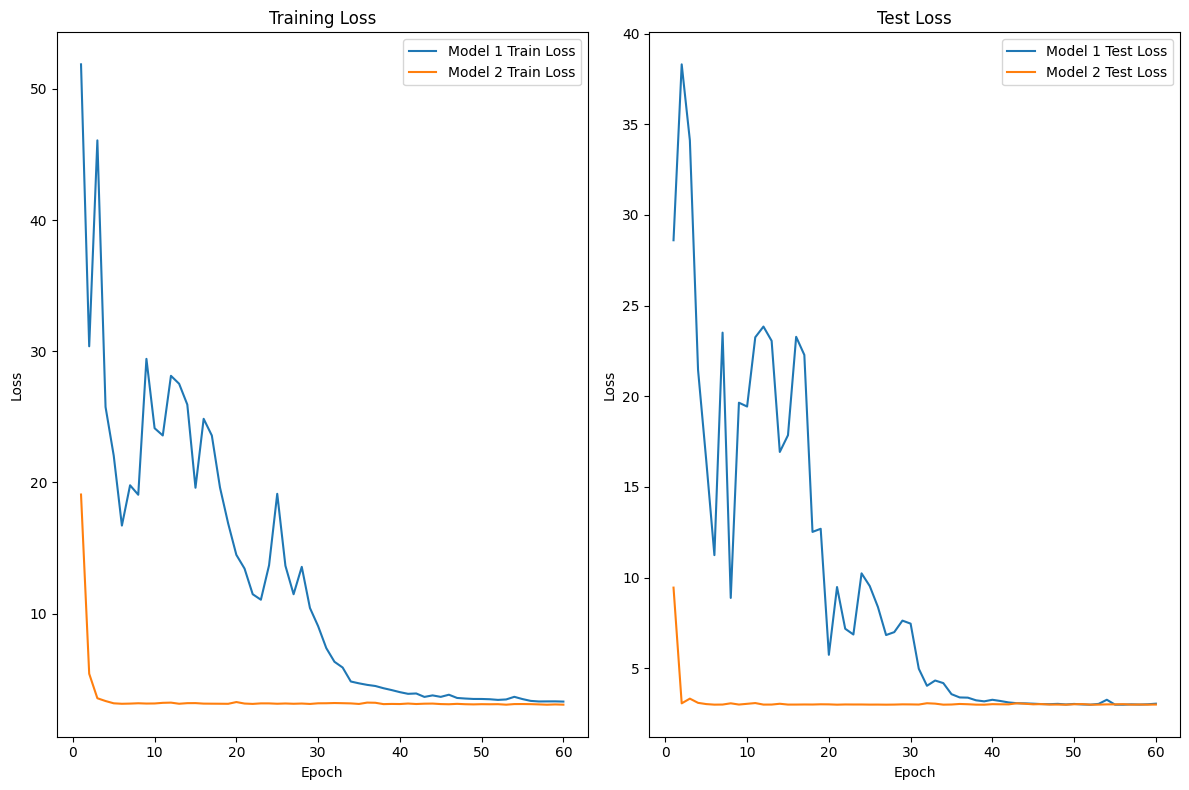

In [55]:
plot_stats(model_1_stats[:60], model_2_stats[:60], 'loss.pdf')

In [40]:
last_30_1, last_30_2 = model_1_stats[60:], model_2_stats[60:]

In [43]:
train_1, train_2 = 0, 0
test_1, test_2 = 0, 0
for i in range(30):
    train_1 += last_30_1[i]['train_loss'][0]
    train_2 += last_30_2[i]['train_loss'][0]
    test_1 += last_30_1[i]['test_loss'][0]
    test_2 += last_30_2[i]['test_loss'][0]

train_1 / 30, train_2 / 30, test_1 / 30, test_2 / 30

(3.1746952266404116,
 3.0960609190391772,
 3.0087149182955426,
 3.0250441074371337)

In [48]:
for epoch in range(30):
    stats = train_epoch(model_1, train_loader, criterion, optimizer_1, encoder)
    model_1_stats.append(stats)

for epoch in range(30):
    stats = train_epoch(model_2, train_loader, criterion, optimizer_2, encoder)
    model_2_stats.append(stats)

  9%|▉         | 1/11 [00:01<00:11,  1.10s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 82%|████████▏ | 9/11 [00:09<00:02,  1.05s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 55%|█████▍    | 6/11 [00:06<00:05,  1.07s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 64%|██████▎   | 7/11 [00:07<00:04,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 55%|█████▍    | 6/11 [00:06<00:05,  1.07s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


t.->t.->t.->t.->t.->t.->t.->t.->['t.', 't.', 't.', 't.', 't.', 't.', 't.', 't.']
t.->['t.']


 73%|███████▎  | 8/11 [00:08<00:03,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 64%|██████▎   | 7/11 [00:07<00:04,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 45%|████▌     | 5/11 [00:05<00:06,  1.01s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


  9%|▉         | 1/11 [00:01<00:10,  1.07s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 82%|████████▏ | 9/11 [00:09<00:02,  1.10s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


th.->th.->th.->the->th.->th.->th.->th.->['th.', 'th.', 'th.', 'the', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 73%|███████▎  | 8/11 [00:08<00:03,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 73%|███████▎  | 8/11 [00:08<00:03,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 27%|██▋       | 3/11 [00:03<00:07,  1.00it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 36%|███▋      | 4/11 [00:04<00:07,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 36%|███▋      | 4/11 [00:04<00:07,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 36%|███▋      | 4/11 [00:04<00:07,  1.05s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 64%|██████▎   | 7/11 [00:06<00:04,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 36%|███▋      | 4/11 [00:04<00:07,  1.07s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 27%|██▋       | 3/11 [00:03<00:08,  1.01s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 18%|█▊        | 2/11 [00:01<00:08,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


tn.->tn.->tn.->tn.->tn.->tn.->tn.->tn.->['tn.', 'tn.', 'tn.', 'tn.', 'tn.', 'tn.', 'tn.', 'tn.']
tn.->['tn.']


  9%|▉         | 1/11 [00:01<00:10,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 27%|██▋       | 3/11 [00:02<00:08,  1.01s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 55%|█████▍    | 6/11 [00:06<00:04,  1.01it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


tu|.->tu|.->tu|.->tu|.->tu|.->tu|.->tu|.->tu|.->['tu|.', 'tu|.', 'tu|.', 'tu|.', 'tu|.', 'tu|.', 'tu|.', 'tu|.']
tu|.->['tu|.']


 45%|████▌     | 5/11 [00:05<00:06,  1.06s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th.->th.->th.->th|.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th|.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 45%|████▌     | 5/11 [00:05<00:06,  1.07s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


the->the->the->th|e->the->the->the->the->['the', 'the', 'the', 'th|e', 'the', 'the', 'the', 'the']
the->['the']


  9%|▉         | 1/11 [00:00<00:09,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


tn.->tn.->th.->th|.->th.->tn.->tn.->th.->['tn.', 'tn.', 'th.', 'th|.', 'th.', 'tn.', 'tn.', 'th.']
th.->['th.']


 36%|███▋      | 4/11 [00:04<00:07,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


tn|.->tn|.->tn|.->tn|.->tn|.->tn|.->tn|.->tn|hh|.->['tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn|hh|.']
tn|.->['tn|.']


 45%|████▌     | 5/11 [00:05<00:06,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th.->th.->th.->th.->th.->th.->th.->th.->['th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.', 'th.']
th.->['th.']


 73%|███████▎  | 8/11 [00:08<00:03,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 27%|██▋       | 3/11 [00:03<00:08,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 64%|██████▎   | 7/11 [00:07<00:04,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 27%|██▋       | 3/11 [00:02<00:07,  1.00it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 36%|███▋      | 4/11 [00:03<00:06,  1.04it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th|.->th|.->th|.->th|.->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 45%|████▌     | 5/11 [00:04<00:05,  1.02it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 55%|█████▍    | 6/11 [00:05<00:05,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 27%|██▋       | 3/11 [00:02<00:07,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:03,  1.00s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|t||.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|t||.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:03,  1.02s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


tn|.->tn|.->tn|.->tn|e->tn|.->tn|.->tn|.->tn||.->['tn|.', 'tn|.', 'tn|.', 'tn|e', 'tn|.', 'tn|.', 'tn|.', 'tn||.']
tn|.->['tn|.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


th|.->th|.->th|.->th|e->th|.->th|.->th|.->th|t|||.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th|.', 'th|.', 'th|t|||.']
th|.->['th|.']


  9%|▉         | 1/11 [00:01<00:10,  1.05s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th|.->th|.->th|.->th|e->th|.->th||.->th|.->th||||.->['th|.', 'th|.', 'th|.', 'th|e', 'th|.', 'th||.', 'th|.', 'th||||.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th||.->th|.->th|.->th|e->th|.->th||.->th|.->th||||.->['th||.', 'th|.', 'th|.', 'th|e', 'th|.', 'th||.', 'th|.', 'th||||.']
th|.->['th|.']


 64%|██████▎   | 7/11 [00:07<00:04,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th||.->th||.->th|.->th||.->th||.->th||.->th|.->th||||.->['th||.', 'th||.', 'th|.', 'th||.', 'th||.', 'th||.', 'th|.', 'th||||.']
th|.->['th|.']


 36%|███▋      | 4/11 [00:03<00:06,  1.07it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


tn|.->tn|.->tn|.->tn|e->tn|.->tn|.->tn|.->tn||||.->['tn|.', 'tn|.', 'tn|.', 'tn|e', 'tn|.', 'tn|.', 'tn|.', 'tn||||.']
tn|.->['tn|.']


 73%|███████▎  | 8/11 [00:07<00:03,  1.03s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


tn||.->tn||.->tn|.->tn|||e->tn|||.->tn||.->tn|.->tn|||||.->['tn||.', 'tn||.', 'tn|.', 'tn|||e', 'tn|||.', 'tn||.', 'tn|.', 'tn|||||.']
tn|.->['tn|.']


 36%|███▋      | 4/11 [00:04<00:07,  1.01s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


th||.->th||.->th|.->th|||e->th|||.->th||.->th|.->th|||||.->['th||.', 'th||.', 'th|.', 'th|||e', 'th|||.', 'th||.', 'th|.', 'th|||||.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:03,  1.00s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


th||.->th||.->th|.->th|||e->th|||.->th||.->th|.->th|||||.->['th||.', 'th||.', 'th|.', 'th|||e', 'th|||.', 'th||.', 'th|.', 'th|||||.']
th|.->['th|.']


 55%|█████▍    | 6/11 [00:05<00:05,  1.00s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


tn||.->tn|.->tn|.->tn||e->tn|.->tn||.->tn|.->tn||||.->['tn||.', 'tn|.', 'tn|.', 'tn||e', 'tn|.', 'tn||.', 'tn|.', 'tn||||.']
tn|.->['tn|.']


 55%|█████▍    | 6/11 [00:05<00:04,  1.00it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


tn|.->tn|.->tn|.->tn|.->tn|.->tn|.->tn|.->tn||||.->['tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn|.', 'tn||||.']
tn|.->['tn|.']


  9%|▉         | 1/11 [00:01<00:10,  1.06s/it]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


tr|||.->tr||.->tr||.->tr|||||||.->tr|||.->tr|||||.->tr|.->tr|||||||||.->['tr|||.', 'tr||.', 'tr||.', 'tr|||||||.', 'tr|||.', 'tr|||||.', 'tr|.', 'tr|||||||||.']
tr|.->['tr|.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


tr||.->tr||.->tr|.->tr|||||||.->tr|||.->tr||.->tr|.->tr||||||||.->['tr||.', 'tr||.', 'tr|.', 'tr|||||||.', 'tr|||.', 'tr||.', 'tr|.', 'tr||||||||.']
tr|.->['tr|.']


  0%|          | 0/11 [00:00<?, ?it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


th||.->th|.->th|.->th|||e->th|.->th||.->th|.->th||||.->['th||.', 'th|.', 'th|.', 'th|||e', 'th|.', 'th||.', 'th|.', 'th||||.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


th||.->th||.->th|.->th|||||||e->th|||.->th|||.->th|.->th||||||||.->['th||.', 'th||.', 'th|.', 'th|||||||e', 'th|||.', 'th|||.', 'th|.', 'th||||||||.']
th|.->['th|.']


  9%|▉         | 1/11 [00:00<00:09,  1.06it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


th||.->th|.->th|.->th|||e->th||.->th||.->th|.->th||||.->['th||.', 'th|.', 'th|.', 'th|||e', 'th||.', 'th||.', 'th|.', 'th||||.']
th|.->['th|.']


 18%|█▊        | 2/11 [00:01<00:08,  1.08it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


th||.->th||.->th|.->th|||e->th||.->th||.->th|.->th|||||.->['th||.', 'th||.', 'th|.', 'th|||e', 'th||.', 'th||.', 'th|.', 'th|||||.']
th|.->['th|.']


  9%|▉         | 1/11 [00:00<00:09,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


th|f|.->th||.->th|.->th|||||e->th||.->th||.->th|.->th||f||||.->['th|f|.', 'th||.', 'th|.', 'th|||||e', 'th||.', 'th||.', 'th|.', 'th||f||||.']
th|.->['th|.']


 73%|███████▎  | 8/11 [00:07<00:02,  1.03it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


th|||.->th||.->th|||.->th|||||||||e->th|||.->th|||||.->th||.->th|||f|||||||f|.->['th|||.', 'th||.', 'th|||.', 'th|||||||||e', 'th|||.', 'th|||||.', 'th||.', 'th|||f|||||||f|.']
th|.->['th|.']


 27%|██▋       | 3/11 [00:02<00:07,  1.09it/s]

Error parsing /kaggle/input/datasets/voyrus/m1p-txd/new_data/c03-000a_2.txd: Неверный формат заголовка: c03-000a_2.bmp  82  ???????


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


th||.->th||.->th|||.->th||||||||e->th|||.->th|||||.->th||.->th|||h|||||||h|.->['th||.', 'th||.', 'th|||.', 'th||||||||e', 'th|||.', 'th|||||.', 'th||.', 'th|||h|||||||h|.']
th|.->['th|.']


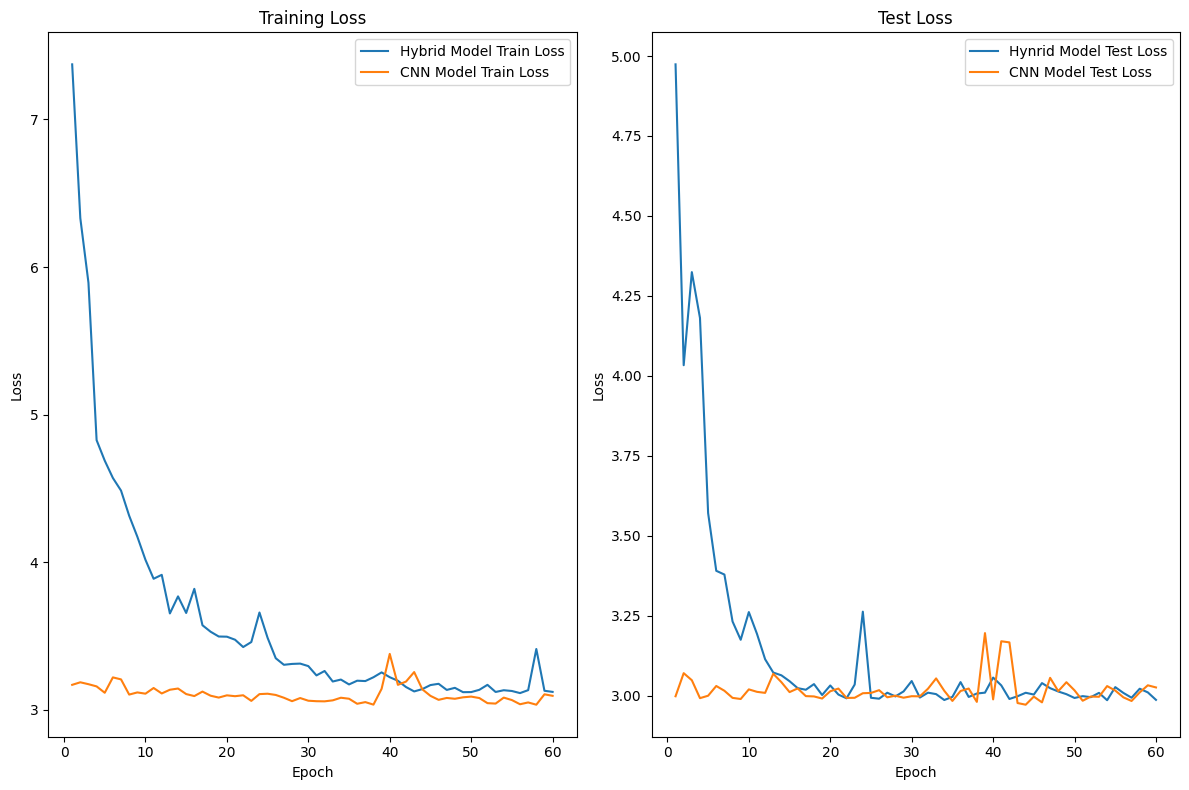

In [61]:
plot_stats(model_1_stats[30:90], model_2_stats[30:90], 'loss1.pdf')